In [1]:
import gaussian_mixture_anomaly_detection as ad
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import numpy as np
import utils
import models
import ewma

reload(ad)
reload(utils)
reload(models)
reload(ewma)
reload(matplotlib)
%matplotlib inline

/Users/sergmiller/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1309: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'MacOSX' by the following code:
  File "/Users/sergmiller/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sergmiller/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.

In [42]:
eff_train = utils.read_ts('data/eff_train/eff_train1.csv')
eff_train = utils.bad_to_mean(eff_train)
eff_train.head()

/Users/sergmiller/Documents/code/python/sibur/GlobalChangersSibur/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[' value'][df[' quality'] != 'Good'] = mean_good


,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good
2,Efficiency,01.10.2016 0:00,16633.79,Good
3,Efficiency,01.10.2016 0:00,17578.13,Good
4,Efficiency,01.10.2016 0:00,17331.05,Good


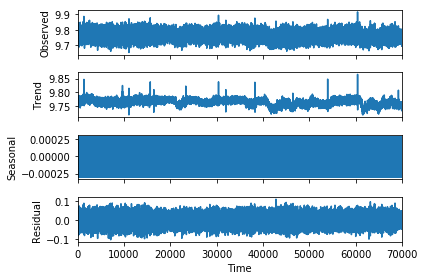

7000


,trend,season,diff
30,9.773675,0.000020,-0.000078
31,9.776969,0.000093,0.002083
32,9.764080,-0.000233,-0.006144
33,9.761250,-0.000304,0.006020


In [43]:
origin_ts = eff_train[' value'][100000:170000].values
lag_to_drop=10
df = utils.get_expanded_features(origin_ts,lag_to_drop=10,plot=True)
dropped_origin = utils.get_dropped(origin_ts, lag=10)
print(len(df))
df.loc[30:33]

In [44]:
import catboost
from sklearn.linear_model import Ridge

remove last elements until period


  0%|          | 0/4 [00:00<?, ?it/s]

Start probabilities memorization


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]
/Users/sergmiller/Documents/code/python/sibur/GlobalChangersSibur/gaussian_mixture_anomaly_detection.py:200: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=5,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


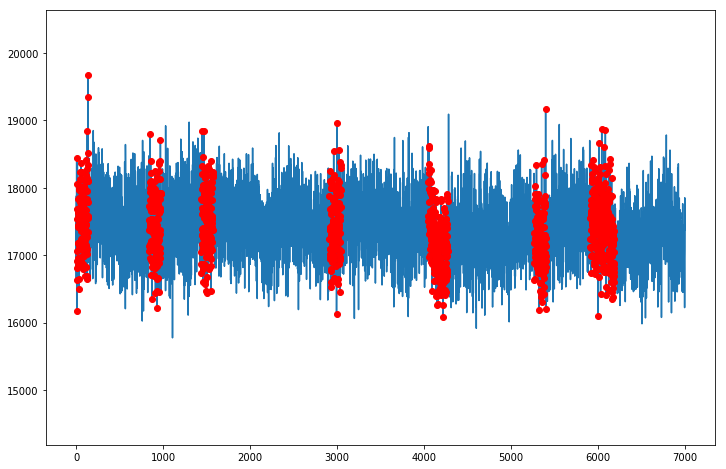

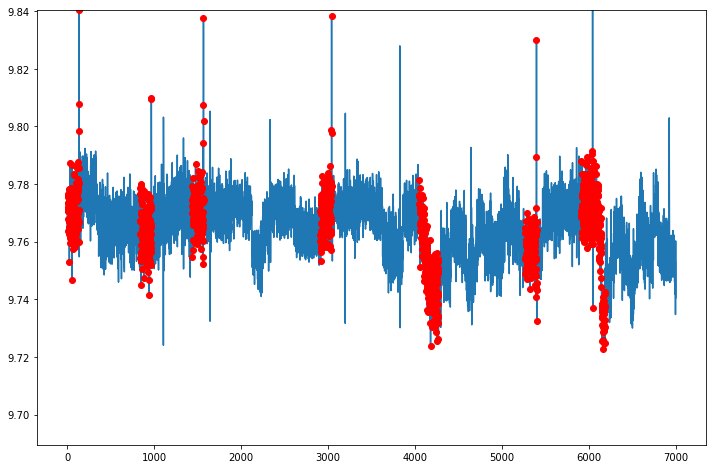

(6868, 396) (7000, 3)
(0.63277293875413654, 0.5790245019464163, 0.022347912159153882, -0.010877184136435014)
CPU times: user 21 s, sys: 929 ms, total: 22 s
Wall time: 21.9 s


In [47]:
%%time
# 2 hour predictions w
targets = utils.get_targets_with_mixture(df, horizont=2 * 6 * 11, halflife=5,
                                         top=0.01, T= 11 * 6 * 24)
utils.plot_with_target(dropped_origin, targets)
utils.plot_with_target(df['trend'].values, targets)
sigmas = ewma.moving_dispersion(df['trend'].values, window=10)
print(models.train_test_run(df, sigmas, targets, 
                            model_sigma=Ridge(normalize=True, tol=0.0001)))